In [1]:
import torch

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


#Generate data

In [3]:
import random
lstX = []
lstY = []
for x in range(-100, 100, 5):
  lstX.append([x])
  y = 3*x + random.uniform(0, 1)*100
  lstY.append([y])

In [4]:
import numpy as np
numpyX = np.array(lstX)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(40, 1) (40, 1)


In [5]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY_hat, testY_hat = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY_hat.shape, testY_hat.shape)

(32, 1) (8, 1) (32, 1) (8, 1)


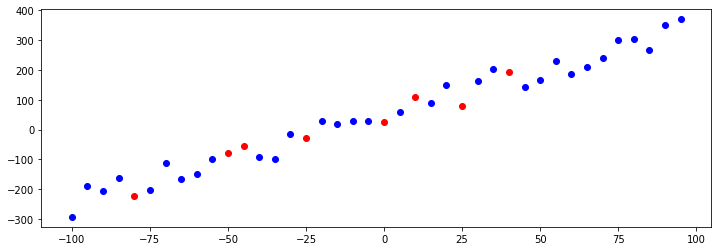

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.scatter(trainX, trainY_hat, color = "blue")
plt.scatter(testX, testY_hat, color = "red")
plt.show()

# Build NN with drop out

In [7]:
import torch.nn as nn

In [8]:
MyNet = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(50, 1),
)
MyNet.to(device)
print(MyNet)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=50, out_features=1, bias=True)
)


In [9]:
from torchsummary import summary
summary(MyNet, input_size=(10, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 10, 100]             200
              ReLU-2              [-1, 10, 100]               0
           Dropout-3              [-1, 10, 100]               0
            Linear-4               [-1, 10, 50]           5,050
              ReLU-5               [-1, 10, 50]               0
           Dropout-6               [-1, 10, 50]               0
            Linear-7                [-1, 10, 1]              51
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [10]:
loss_func = torch.nn.MSELoss()

In [11]:
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.005)

# Train N epoches with drop out

In [12]:
tensorX = torch.FloatTensor(trainX).to(device)
tensorY_hat = torch.FloatTensor(trainY_hat).to(device)

In [13]:
lossLst = []
for epoch in range(1, 500):
    tensorY = MyNet(tensorX)
    loss = loss_func(tensorY_hat, tensorY)
    lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

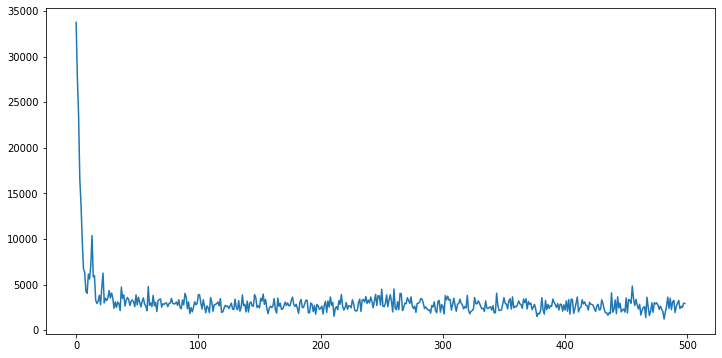

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(lossLst)
plt.show()

#model.eval() will turn model to test mode and PyTorch will automatically handle weight scaling of the dropout layer

In [15]:
MyNet.eval()

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=50, out_features=1, bias=True)
)

##Training data performance

In [16]:
tensorY = MyNet(tensorX)
loss = loss_func(tensorY, tensorY_hat)
print("%.2f" % (float(loss)))

1368.40


In [17]:
trainY = tensorY.detach().cpu().numpy()

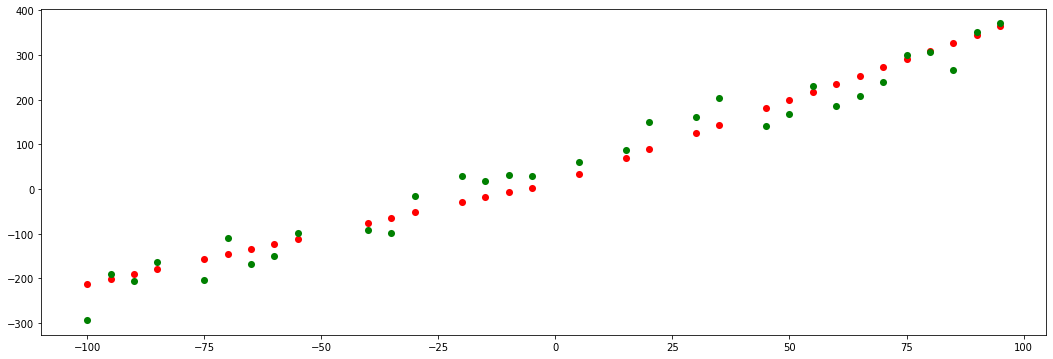

In [18]:
plt.figure(figsize=(18, 6))
plt.scatter(trainX, trainY, s=50, lw=0, color="red")
plt.scatter(trainX, trainY_hat, s=50, lw=0, color="green")
plt.show()

# Test 

In [19]:
tensorX = torch.FloatTensor(testX).to(device)
tensorY_hat = torch.FloatTensor(testY_hat).to(device)
tensorY = MyNet(tensorX)
loss = loss_func(tensorY, tensorY_hat)
print("%.2f" % (float(loss)))

1254.87


In [20]:
testY = tensorY.detach().cpu().numpy()

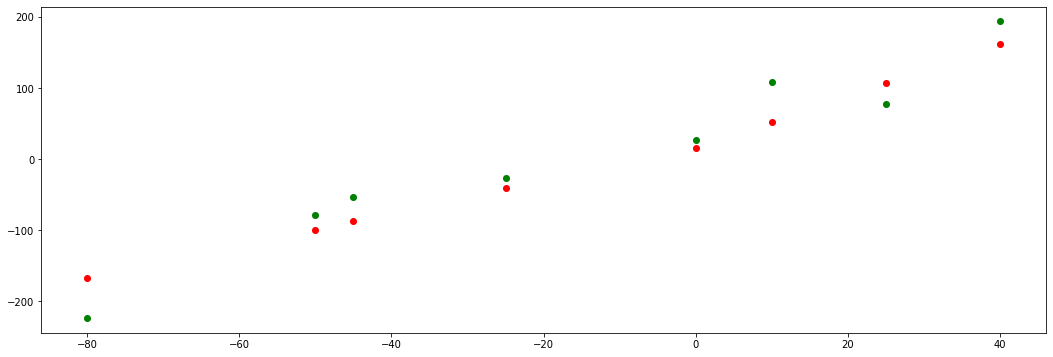

In [21]:
plt.figure(figsize=(18, 6))
plt.scatter(testX, testY, s=50, lw=0, color="red")
plt.scatter(testX, testY_hat, s=50, lw=0, color="green")
plt.show()